In [2]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

In [3]:
warnings.filterwarnings('ignore') 
inceptionV3_model = keras.applications.inception_v3.InceptionV3() #Load pretrained model

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-02-02 07:45:57.139461: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-02 07:45:57.140013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


96112376/96112376 [==============================] - 103s 1us/step


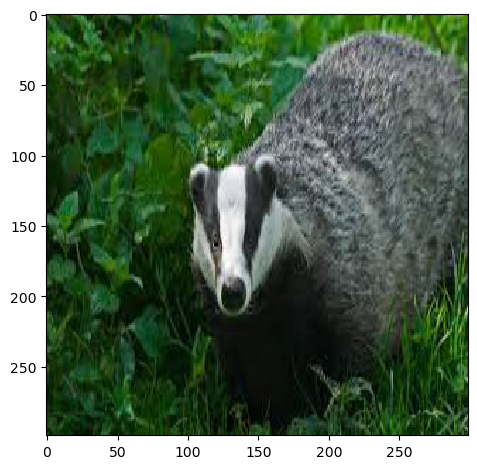

In [4]:
Xi = skimage.io.imread("/Users/yohanabeysinghe/Mac/1. ENTC/FYP - Ear EEG/Datasets/Animal Image Dataset/animals/animals/badger/0c29e0107f.jpg")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5)

In [5]:
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)

2024-02-02 07:53:10.560011: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-02 07:53:10.994669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35363/35363 [==============================] - 0s 2us/step


[[('n02447366', 'badger', 0.92659706),
  ('n02445715', 'skunk', 0.0038643805),
  ('n02441942', 'weasel', 0.0011924052),
  ('n02510455', 'giant_panda', 0.0011460279),
  ('n02783161', 'ballpoint', 0.0011002597)]]

In [6]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes

array([362, 361, 356, 388, 418])

In [18]:
Xi.shape

(299, 299, 3)

In [7]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

60

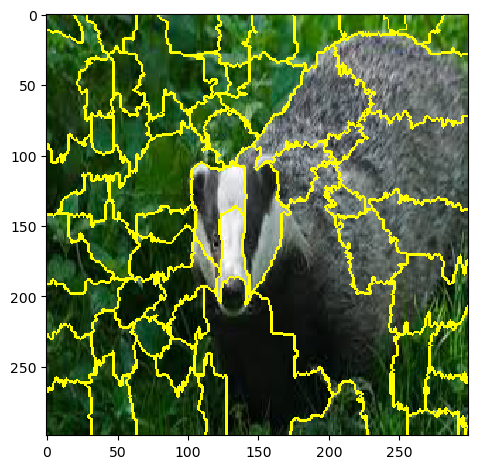

In [8]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [9]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0]


array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0])

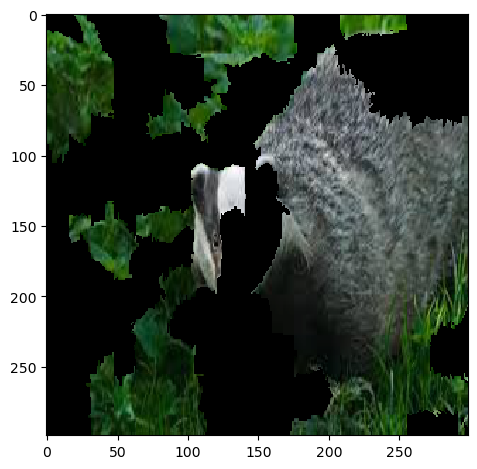

In [10]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image


skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [11]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

1/1 [==============================] - 0s 32ms/step


(150, 1, 1000)

In [12]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [13]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [14]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.04749671, -0.05841849,  0.034833  ,  0.08863201,  0.06040061,
        0.06951469, -0.02626699, -0.02652605, -0.03892772,  0.05078004,
        0.09509618,  0.03753479,  0.02683265,  0.07630756,  0.02453532,
       -0.008161  ,  0.08984123,  0.06186735,  0.08561342, -0.00414649,
       -0.05236647,  0.08693715,  0.02668978, -0.00247839, -0.11722691,
        0.02338907,  0.01145741, -0.01014069,  0.04063937,  0.30901226,
        0.33363253,  0.02640946, -0.00670137, -0.03117215,  0.19302281,
        0.0188677 , -0.01757881, -0.01791552,  0.05207728,  0.08414734,
       -0.01046087,  0.04186753, -0.03767589,  0.01447582,  0.13431935,
        0.19887295, -0.02387095,  0.01144414,  0.00688123, -0.03291008,
        0.01568045,  0.01174165,  0.01351273, -0.00328743,  0.06008503,
       -0.04291701,  0.0146622 , -0.09410748,  0.00066746, -0.06466444])

In [16]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([34, 45, 29, 30])

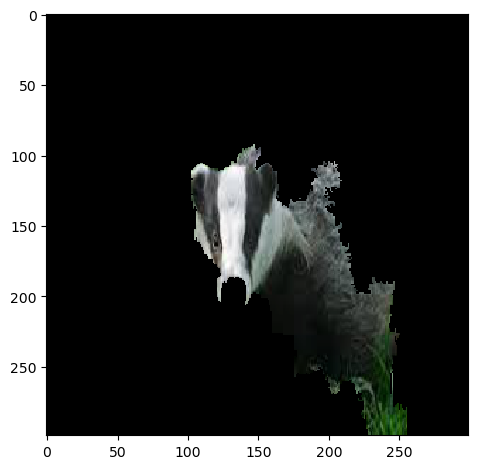

In [17]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )